## Final Project Submission

Please fill out:
* Student name: Julia Müller
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Mark Barbour
* Blog post URL:


In [1]:
# loading basic packages for data manipulation & visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

In [2]:
%cd data

C:\Users\mullerju\Documents\Flatiron\Course_Material\Phase_2\dsc-phase-2-project-v2-5\data


### Data preparation
In this section, the data will be loaded and inspected. I will decide what to do with missing values, duplicates and outliers. I will also see if any variables will have to be scaled and do one-hot-encoding with categorical variables.

In [3]:
df = pd.read_csv("kc_house_data.csv") #read csv
df.info() #inspect and see only few NAs
df.dropna(inplace=True) #drop all rows with nas
df = df.drop_duplicates() #drop duplicate rows
df.drop(["id"], axis=1, inplace=True) #drop too detailed information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [23]:
#For all variables, I want to see the values distribution
for column in df.columns:
    print(f"Unique values in column '{column}': \n{df[column].unique()}")
    print(f"Values distribution '{column}': \n{df[column].value_counts()}\n")

Unique values in column 'bedrooms': 
[ 4  5  6  3  2  1  8 10  7  9 11]
Values distribution 'bedrooms': 
3     12332
4      9491
2      3546
5      2735
6       465
1       369
7        68
8        32
9        10
11        1
10        1
Name: bedrooms, dtype: int64

Unique values in column 'bathrooms': 
[1.  2.5 2.  3.  1.5 3.5 4.  5.5 4.5 5. ]
Values distribution 'bathrooms': 
2.5    8176
2.0    6942
1.0    4536
3.0    4078
3.5    2153
1.5    1764
4.0     637
4.5     523
5.0     142
5.5      99
Name: bathrooms, dtype: int64

Unique values in column 'sqft_living': 
[1180 2770 2880 ... 3291 4825 1797]
Values distribution 'sqft_living': 
1400    184
1560    181
1900    180
1250    178
1540    171
       ... 
360       1
2281      1
2265      1
2105      1
2049      1
Name: sqft_living, Length: 1243, dtype: int64

Unique values in column 'sqft_lot': 
[ 7140  6703  6156 ...  3249  1141 11058]
Values distribution 'sqft_lot': 
5000     478
6000     399
4000     372
7200     297
7500     181


In [4]:
#I want to calculate from the two date columns how old the house was when it was sold. for this i will subtract
#the date it was built from the date it was sold and get a new column with the age.
df["date"] = df["date"].str[-4:].apply(int)
delta = df["date"] - df["yr_built"]
df["age"] = delta
df.drop(["date", "yr_built"], axis=1, inplace=True) #drop too detailed information

There are two findings: there are houses with no bedrooms and houses with 0 or 0.5 bathrooms. We would expect every house to at least have 1 bedroom and at least 1 bathroom with shower or bathtub. We therefore exclude these observations from the dataset. Also, our customer is a real-estate agency with focus on 1 family homes. Therefore, we exclude all homes with more than 5 bathrooms from the dataset.

In [5]:
df = df[(df["bathrooms"] < 6) & (df["bathrooms"] >= 1)] #excluding objects with more than 5.5 bathrooms and less than 1
df = df[df["bedrooms"] >= 1]

Regarding the location, there seem to be objects outside of King County. I will remove all objects outside of the state of Washington

In [ ]:
import plotly.express as px
# Create a scatter mapbox figure with the DataFrame
fig = px.scatter_mapbox(df, lat='lat', lon='long')

# Set the mapbox style
fig.update_layout(mapbox_style='open-street-map')

# Show the figure
fig.show()

In [6]:
import re
# regex pattern to extract the state 
pattern = r',\s+([A-Za-z ]+?)\s+\d{5},'
# apply regex to the 'address' column and store the results in a new 'state' column
df['state'] = df['address'].apply(lambda x: re.findall(pattern, x)[0])
df = df[df["state"]=="Washington"] #removing all objects outside of Washington state

In [7]:
from haversine import haversine, Unit
# coordinates of Seattle
seattle = (47.6062, -122.3321)

# calculate the distance from each object to Seattle in km and store the result in a new column
df['distance_to_seattle_km'] = df.apply(lambda row: haversine((row['lat'], row['long']), seattle, unit=Unit.KILOMETERS), axis=1)
df = df[df["distance_to_seattle_km"] < 200]
df.drop(["lat", "long", "address", "state"], axis=1, inplace=True) #drop too detailed information

For Waterfront, greentbelt, nuisance, view, condition, grade, heat source and sewer system, we can create categorical dummy variables. Looking at the values distribution and the most common values, an average house would consist of the following attributes: 

Waterfront: no
Greenbelt: no
Nuisance: no
View: None
Condition: Average
Grade: Avaerage
Heat source: Gas
Sewer System: Public

I will change the grade of the house and the condition to a numerical column. Also, I will summarize small categories from the variables heat source and sewer system. I will also create categorical columns for objects if they have a basement, garage and patio

In [8]:
#converting the Grade and condition column to an integer. I'm assuming ordinality.
df['grade'] = df['grade'].str.split().str[0].astype(int) 
df["condition"] = df["condition"].replace({'Good': 4, 'Average': 3, 'Very Good': 5, 'Fair': 2, 'Poor': 1})
df["heat_source"] = df["heat_source"].replace({'Gas/Solar': "Other", "Electricity/Solar": "Other", "Oil/Solar": "Other"})
df["sewer_system"] = df["sewer_system"].replace({'PRIVATE RESTRICTED': "PRIVATE", "PUBLIC RESTRICTED": "PUBLIC"})
#Finally, I will transform year built to years
#the maximum is 2022, so I will subtract the year from 2022
#df["yr_built"] = 2022-df["yr_built"]
#for year renovated I will create a categorical column with 0/1
ren = []
for value in df["yr_renovated"]:
    if value < 2000:
        ren.append("0")
    else:
        ren.append("1")
df["renovated"] = ren
df.drop(["yr_renovated"], axis=1, inplace=True)
#also, i will make a categorical column out of if there is a basement, garage or patio or not
cols = ["sqft_garage", "sqft_basement", "sqft_patio"]
for col in cols:
    df[col] = df[col].apply(lambda x: 'YES' if x > 0 else 'NO')
df = df.rename(columns={"sqft_garage":"garage","sqft_basement":"basement","sqft_patio": "patio" })

In [ ]:
nrows = round(len(df.columns)/2)
fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 64))
axs = axs.flatten()

for i, column in enumerate(df.columns):
    axs[i].hist(df[column])
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('count')

plt.tight_layout()
plt.show()

In [ ]:
# Check continuous predictors for outliers using Boxplot 

outliers = ["price",'bedrooms', 'bathrooms', 'sqft_living', 'sqft_above', 'sqft_lot']

for outlier in outliers:
    plt.boxplot(df[outlier])
    plt.title(outlier)
    plt.show()

#### Interpretation of the Histograms:
The price seems to have a lot of outliers. This might have to be transformed - i will try first a log transformation
For the bedrooms, houses have between 0 and 10 bedrooms while the majority have 3.
For the bathrooms, houses have between 1 and 6 bathrooms while the majority have 2.
For sqft living, we also have a slight positive skew. The most common value seems to be around 2000 sqft.
For sqft lot, there seem to be many extreme outliers which we might have to remove.
Floors is shown in 0.5 steps, the majority have either 1 or 2 floors.
waterfront only has few yes.
greenbelt only has few yes.
nuisance only has few yes.
the view is mostly None.
the condition is mostly average.
the grade as well.
the most common heat source is gas.
the sewer system is either public or private.
sqft above and sqft basement are positively skewed.
sqft garage and patio have outliers that may have to be removed.
year built starts in 1900 and has its peak in 2020.
year renovates seems to have a lot of missing values which we will have to remove.



In [9]:
df["price_log"] = np.log(df["price"])

In [ ]:
#checking the variable distribution again
nrows = round(len(df.columns)/2)
fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 64))
axs = axs.flatten()

for i, column in enumerate(df.columns):
    axs[i].hist(df[column])
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('count')

plt.tight_layout()
plt.show()

#### Interpretation of histograms
Looking at the plots, the transformation has helped. I will drop the original price column.
Some variables (especially the categorical ones) don't seem to be suitable to include in the model.

In [10]:
df.drop(["price"], axis=1, inplace=True)

#### One Hot Encoding
I will create dummy variables for the categorical columns so that we can evaluate if we include them in the linear regression model.

In [14]:
y = df["price_log"]
X = df.drop(["price_log"], axis=1)
X = pd.get_dummies(X, columns=["waterfront", "basement", "garage", "patio","greenbelt", "nuisance","view", "heat_source", "sewer_system", "renovated"], drop_first=False)
X = X.drop(["waterfront_NO", "greenbelt_NO","patio_NO", "garage_NO","nuisance_NO","basement_NO", "view_NONE","heat_source_Gas", "sewer_system_PUBLIC", "renovated_0"], axis=1)

### Feature selection
In this section, I'm looking at which features to include in the regression model. 

In [ ]:
corrmat = pd.concat([y,X], axis=1)
corrmat.corr()["price_log"]

In [ ]:
fig, axs = plt.subplots(nrows=int(len(X.columns)/2), ncols=2, figsize=(16, 64))
axs = axs.flatten()

for i, column in enumerate(X.columns):
    axs[i].scatter(X[column], y)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('price_log')

plt.tight_layout()
plt.show()

In [ ]:
#checking for multicollinearity
cormat=X.corr().abs().stack().reset_index().sort_values(0, ascending=False)
# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
cormat['pairs'] = list(zip(cormat.level_0, cormat.level_1))
# set index to pairs
cormat.set_index(['pairs'], inplace = True)
#d rop level columns
cormat.drop(columns=['level_1', 'level_0'], inplace = True)
# rename correlation column as cc rather than 0
cormat.columns = ['cc']
# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
cormat.drop_duplicates(inplace=True)
cormat[(cormat.cc>.75) & (cormat.cc <1)]

From the correlation matrix  for price, we can see that the highest correlations are grade, sqft_living, sqft_above, bathrooms, bedrooms. I will combine certain categorical values to reduce the amount of variables. The sewer system can be ignored for the model as it does not seem to have large correlations. I will also drop the sqft_living columns due to high correlation with bathrooms and sqft above. 

In [15]:
X = X.drop(["sqft_living"], axis=1) #dropping sqft_living due to high correlation with sqft_living and bathrooms
model_base = sm.OLS(y, sm.add_constant(X))
results_base = model_base.fit()
print(results_base.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     1567.
Date:                Sat, 18 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:05:47   Log-Likelihood:                -13243.
No. Observations:               29050   AIC:                         2.654e+04
Df Residuals:                   29025   BIC:                         2.674e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### Interpretation of the baseline model
The model explains around 56% of the variance and is significant. If all features are 0, the house would sell for 174000 USD (exp(12). Some variables are not significant (greenbelt, renovated, heat source) and for others the coefficient does not really make sense.  I will start dropping features step by step to see how the model improves. 

In [ ]:
fig, axs = plt.subplots(nrows=int(len(X.columns)/2), ncols=2, figsize=(16, 64))
axs = axs.flatten()

for i, column in enumerate(X.columns):
    axs[i].scatter(X[column], y)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('price')

plt.tight_layout()
plt.show()

I will now drop variables that do not make sense based on the scatter plot. from the continous variables sqft lot does not look good. Also, condition, bedrooms and floors will be excluded. 

In [20]:
X2 = X.drop(["sqft_lot", "condition", "bedrooms","floors"], axis=1) #dropping sqft_living due to high correlation with sqft_living and bathrooms
model_v2 = sm.OLS(y, sm.add_constant(X2))
results_v2 = model_v2.fit()
print(results_v2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     1772.
Date:                Sat, 18 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:10:01   Log-Likelihood:                -13728.
No. Observations:               29050   AIC:                         2.750e+04
Df Residuals:                   29029   BIC:                         2.767e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

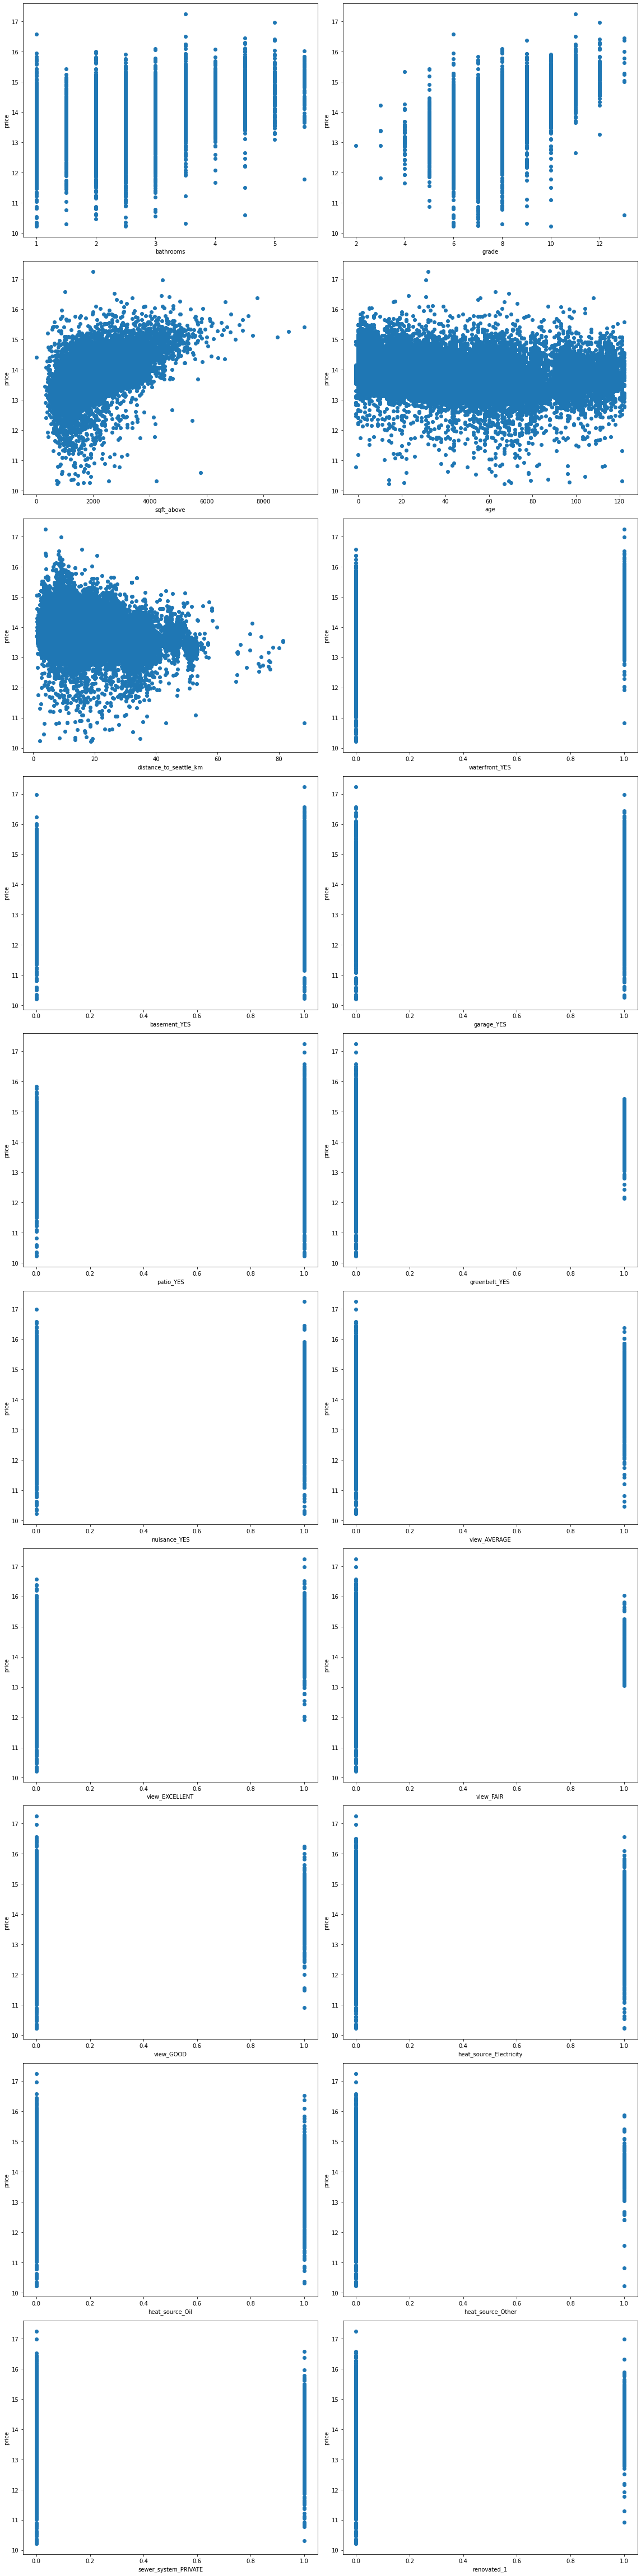

In [21]:
fig, axs = plt.subplots(nrows=int(len(X2.columns)/2), ncols=2, figsize=(16, 64))
axs = axs.flatten()

for i, column in enumerate(X2.columns):
    axs[i].scatter(X2[column], y)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('price')

plt.tight_layout()
plt.show()

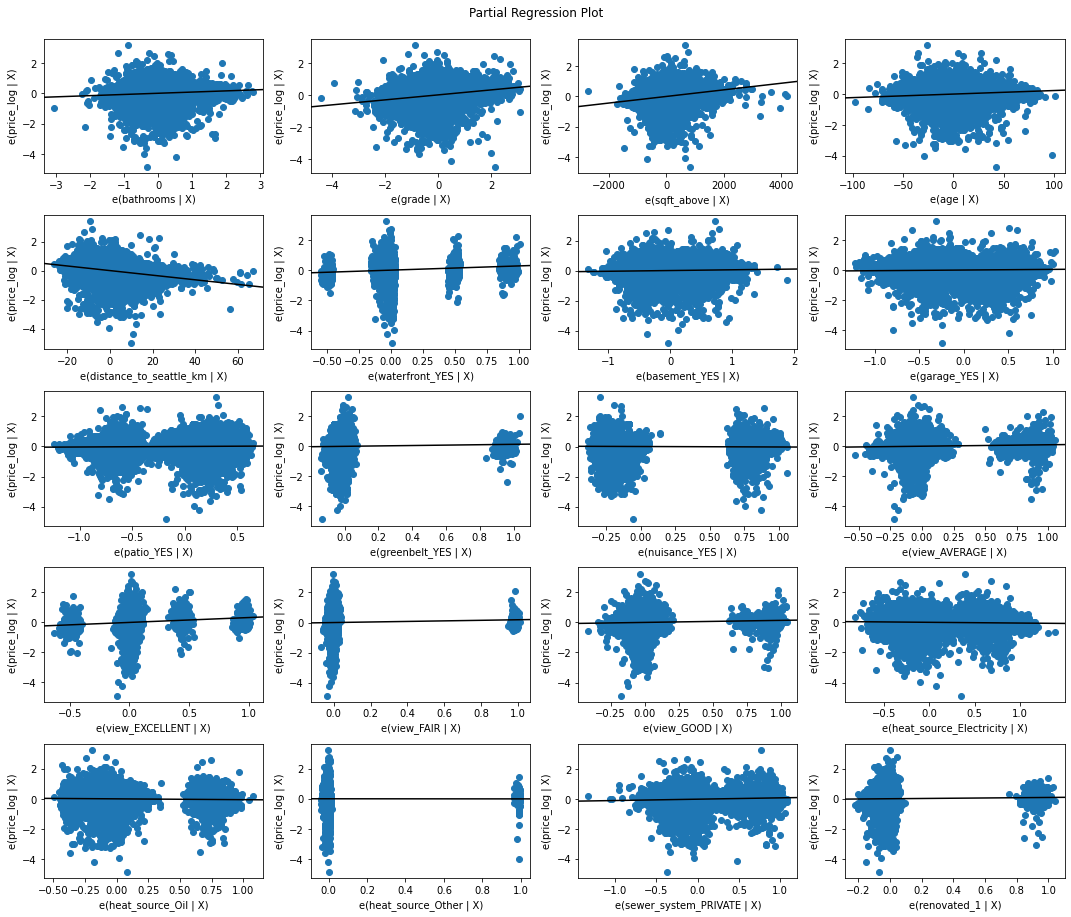

In [24]:
fig = plt.figure(figsize=(15,15))
sm.graphics.plot_partregress_grid(
    results_v2,
    exog_idx=list(X2.columns.values),
    grid=(6,4),
    fig=fig)
plt.show()